In [10]:
import numpy as np
from scipy.misc import factorial

def P(l, m, x):
    # evaluate an Associated Legendre Polynomial P(l,m,x) at x
    pmm = 1.0;
    if (m > 0):
        somx2 = np.sqrt((1.0-x)*(1.0+x))
        fact = 1.0
        i = 1
        while i <= m:
            pmm *= (-fact) * somx2
            fact += 2.0
            i += 1
    
    if (l == m):
        return pmm
        
    pmmp1 = x * (2.0*m+1.0) * pmm
    
    if (l == m+1):
        return pmmp1
    
    pll = 0.0
    ll = m+2
    while ll <= l:
        pll = ( (2.0*ll-1.0)*x*pmmp1-(ll+m-1.0)*pmm ) / (ll-m)
        pmm = pmmp1
        pmmp1 = pll
        ll += 1
    
    return pll

def K(l, m):
    #  renormalisation constant for SH function
    temp = ((2.0*l+1.0)*factorial(l-m)) / (4.0*np.pi*factorial(l+m))
    return np.sqrt(temp)

def sph_harm(m, l, theta, phi):
    theta, phi = phi, theta
    #  return a point sample of a Spherical Harmonic basis function
    #  l is the band, range [0..N]
    #  m in the range [-l..l]
    #  theta in the range [0..Pi]
    #  phi in the range [0..2*Pi]
    sqrt2 = np.sqrt(2.0)
    if (m == 0):
        return K(l,0)*P(l,m,np.cos(theta))
    elif (m > 0):
        return sqrt2*K(l,m)*np.cos(m*phi)*P(l,m,np.cos(theta))
    else:
        return sqrt2*K(l,-m)*np.sin(-m*phi)*P(l,-m,np.cos(theta))

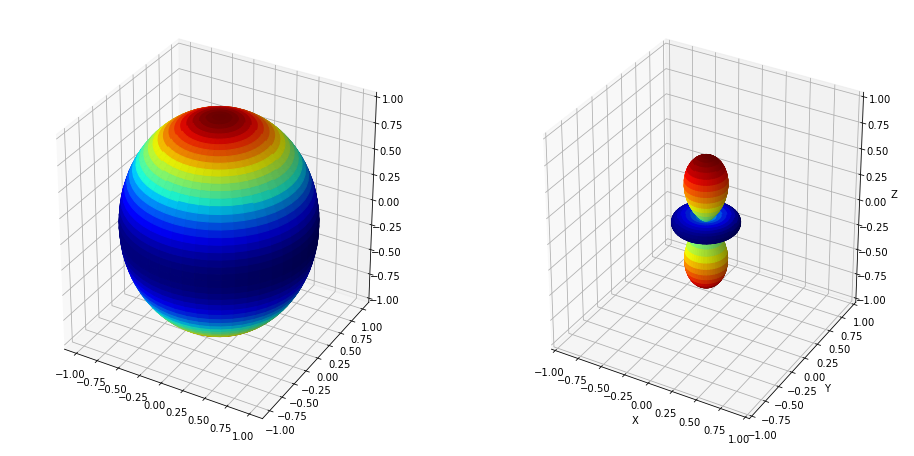

In [19]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d.axes3d import Axes3D, get_test_data
from matplotlib import cm, colors
from scipy.special import sph_harm

# Set the aspect ratio to 1 so our sphere looks spherical
fig = plt.figure(figsize=[16, 8])

# convention of scipy: theta is the azimuthal angle and phi is the polar angle
phi = np.linspace(0, np.pi, num=50)
theta = np.linspace(0, 2*np.pi, num=50)
phi, theta = np.meshgrid(phi, theta)

x = np.sin(phi) * np.cos(theta)
y = np.sin(phi) * np.sin(theta)
z = np.cos(phi)

m, l = 0, 2
sh = sph_harm(m, l, theta, phi).real
absSh = np.abs(sh)
sh_min, sh_max = sh.min(), sh.max()
sh_max += 0.000001
gradient = (sh - sh_min) / (sh_max - sh_min)

#===============
# set up the axes for the first plot
ax = fig.add_subplot(121, projection='3d')
surf = ax.plot_surface(x, y, z, facecolors=cm.jet(gradient))

ax = fig.add_subplot(122, projection='3d')
surf = ax.plot_surface(x*absSh, y*absSh, z*absSh, facecolors=cm.jet(gradient))

ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])
ax.set_zlim([-1, 1])
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()

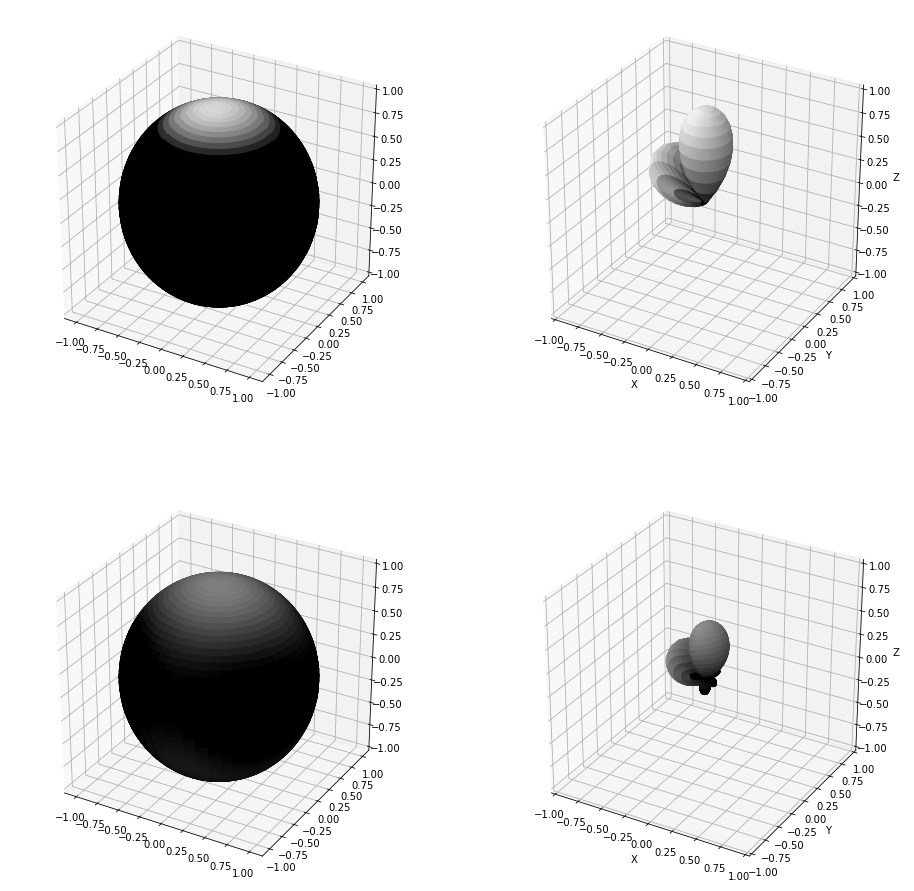

In [12]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.axes3d import Axes3D, get_test_data
from matplotlib import cm, colors
import numpy as np

# configurations
sh_bands = 4
sample_cnt = 50
mc_estimator_cnt = 2048

def light_func(phi, theta):
    l = np.maximum(0, 5*np.cos(phi)-4) + np.maximum(0, -4*np.sin(phi-np.pi)*np.cos(theta-2.5)-3)
    return l

def sample_sphere_uniform(sample):
    phi = np.arccos(1.0 - 2.0 * sample[0])
    theta = 2.0 * np.pi * sample[1]
    pdf = 1.0 / (4.0 * np.pi)
    return phi, theta, pdf

def project_light_to_sh():
    sh_coeffs = np.ndarray(sh_bands**2)
    sh_coeffs.fill(0)

    samples0 = np.random.uniform(0, 1, mc_estimator_cnt)
    samples1 = np.random.uniform(0, 1, mc_estimator_cnt)
    for sampleIdx in range(mc_estimator_cnt):
        phi, theta, pdf = sample_sphere_uniform([samples0[sampleIdx], samples1[sampleIdx]])

        light_val = light_func(phi, theta)
        weight = 1.0 / pdf / mc_estimator_cnt
        
        for l in range(sh_bands):
            for m in range(-l, l + 1):
                sh_val = sph_harm(m, l, theta, phi).real     
                i = l * (l + 1) + m
                sh_coeffs[i] = sh_coeffs[i] + light_val * sh_val * weight

    return sh_coeffs

def reconstruct_light_func(phi, theta, sh_coeffs):
    lights = 0
    for l in range(sh_bands):
        for m in range(-l, l + 1):
            sh = sph_harm(m, l, theta, phi).real
            i = l * (l + 1) + m
            coeff = sh_coeffs[i]
            lights = lights + sh * coeff
    return lights
    

# Set the aspect ratio to 1 so our sphere looks spherical
fig = plt.figure(figsize=[16, 16])


# convention of scipy: theta is the azimuthal angle and phi is the polar angle
phi = np.linspace(0, np.pi, num=sample_cnt)
theta = np.linspace(0, 2*np.pi, num=sample_cnt)
phi, theta = np.meshgrid(phi, theta)

x = np.sin(phi) * np.cos(theta)
y = np.sin(phi) * np.sin(theta)
z = np.cos(phi)

# plot light function
lightRadiances = light_func(phi, theta)
ax = fig.add_subplot(221, projection='3d')
surf = ax.plot_surface(x, y, z, rcount=200, ccount=200, facecolors=cm.gray(lightRadiances))

ax = fig.add_subplot(222, projection='3d')
ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])
ax.set_zlim([-1, 1])
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
surf = ax.plot_surface(x*np.abs(lightRadiances), y*np.abs(lightRadiances), z*np.abs(lightRadiances), facecolors=cm.gray(lightRadiances))

# project light function to SH
sh_coeffs = project_light_to_sh()

# plat approx function
l = reconstruct_light_func(phi, theta, sh_coeffs)
ax = fig.add_subplot(223, projection='3d')

surf = ax.plot_surface(x, y, z, rcount=200, ccount=200, facecolors=cm.gray(l))
ax = fig.add_subplot(224, projection='3d')
ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])
ax.set_zlim([-1, 1])
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
surf = ax.plot_surface(x*np.abs(l), y*np.abs(l), z*np.abs(l), facecolors=cm.gray(l))

plt.show()

## References

* [Spherical Harmonics for Beginners](https://dickyjim.wordpress.com/2013/09/04/spherical-harmonics-for-beginners/)
* [Spherical Harmonic Lighting: The Gritty Details](references/spherical-harmonic-lighting.pdf)
